In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load results

In [21]:
import pandas as pd
import pathlib

import pickle
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [22]:
output_dir = 'results/results-overall-drift-datasets-noise-0.1'

In [23]:
for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:

    
    filename = f"{output_dir}/{exp_type}_drift_results_overall.pkl"
    if not pathlib.Path(filename).exists():
        print(f"File {filename} not found")
        continue

    with open(filename, "rb") as f:
        overall_drift_results = pickle.load(f)
    
    threshold = 0


    res = []
    for method in overall_drift_results:

        overall_drift_result = overall_drift_results[method]
        # overall_drift_result[i]['drift'] is 1 if the experiment i has drift, 0 otherwise. We use this as the ground truth
        # Half of the experiments have drift, half do not
        gt = [overall_drift_result[i]['drift'] for i in range(len(overall_drift_result))]
        
        # Predictions are the number of drift points detected by the method
        predictions = [overall_drift_result[i]['num_pts_detected'] for i in range(len(overall_drift_result))]
        
        
        # We say that drift is detected if the number of drift points detected is greater than a threshold
        predictions = list([pred > threshold for pred in predictions])
        #Convert to int predictions
        predictions=list(map(int, predictions))


        acc = accuracy_score(gt, predictions)

        f1 = f1_score(gt, predictions, average='macro')

        tn, fp, fn, tp = confusion_matrix(gt, predictions).ravel()

        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        res.append([method, acc, f1, fpr, fnr])

    res = pd.DataFrame(res, columns=["method", "accuracy", "f1", "fpr", "fnr"])
    print(exp_type)
    display(res)

agrawal


,method,accuracy,f1,fpr,fnr
0,hddma_0.0001,1.00,1.000000,0.00,0.00
1,hddma_0.0002,1.00,1.000000,0.00,0.00
2,hddma_0.001,1.00,1.000000,0.00,0.00
3,hddma_0.002,0.99,0.989999,0.02,0.00
4,hddma_0.01,0.95,0.949875,0.10,0.00
5,hddma_0.02,0.93,0.929655,0.14,0.00
6,ddm_5,0.96,0.959936,0.08,0.00
7,ddm_10,0.97,0.969973,0.06,0.00
8,ddm_30,0.97,0.969973,0.06,0.00
9,ddm_50,0.96,0.959936,0.08,0.00


sea


,method,accuracy,f1,fpr,fnr
0,hddma_0.0001,0.50,0.333333,0.00,1.00
1,hddma_0.0002,0.50,0.333333,0.00,1.00
2,hddma_0.001,0.48,0.324324,0.04,1.00
3,hddma_0.002,0.48,0.324324,0.04,1.00
4,hddma_0.01,0.48,0.368626,0.10,0.94
5,hddma_0.02,0.49,0.409107,0.14,0.88
6,ddm_5,0.52,0.376299,0.00,0.96
7,ddm_10,0.52,0.376299,0.00,0.96
8,ddm_30,0.52,0.376299,0.00,0.96
9,ddm_50,0.51,0.355178,0.00,0.98


led


,method,accuracy,f1,fpr,fnr
0,hddma_0.0001,0.50,0.333333,0.00,1.00
1,hddma_0.0002,0.51,0.355178,0.00,0.98
2,hddma_0.001,0.50,0.350312,0.02,0.98
3,hddma_0.002,0.51,0.371069,0.02,0.96
4,hddma_0.01,0.47,0.405229,0.20,0.86
5,hddma_0.02,0.42,0.395833,0.38,0.78
6,ddm_5,0.47,0.319728,0.06,1.00
7,ddm_10,0.47,0.319728,0.06,1.00
8,ddm_30,0.47,0.319728,0.06,1.00
9,ddm_50,0.47,0.319728,0.06,1.00


hyper


,method,accuracy,f1,fpr,fnr
0,hddma_0.0001,0.90,0.898990,0.00,0.20
1,hddma_0.0002,0.91,0.909265,0.00,0.18
2,hddma_0.001,0.92,0.919485,0.00,0.16
3,hddma_0.002,0.92,0.919711,0.02,0.14
4,hddma_0.01,0.89,0.889901,0.14,0.08
5,hddma_0.02,0.85,0.848775,0.24,0.06
6,ddm_5,0.92,0.919485,0.00,0.16
7,ddm_10,0.90,0.898990,0.00,0.20
8,ddm_30,0.91,0.909265,0.00,0.18
9,ddm_50,0.95,0.949875,0.00,0.10


stagger


,method,accuracy,f1,fpr,fnr
0,hddma_0.0001,1.00,1.000000,0.0,0.00
1,hddma_0.0002,1.00,1.000000,0.0,0.00
2,hddma_0.001,1.00,1.000000,0.0,0.00
3,hddma_0.002,1.00,1.000000,0.0,0.00
4,hddma_0.01,1.00,1.000000,0.0,0.00
5,hddma_0.02,1.00,1.000000,0.0,0.00
6,ddm_5,1.00,1.000000,0.0,0.00
7,ddm_10,1.00,1.000000,0.0,0.00
8,ddm_30,1.00,1.000000,0.0,0.00
9,ddm_50,1.00,1.000000,0.0,0.00


# Load the result and plot them

In [24]:
res_dataset_method_noise = {}

for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:
    res_dataset_method_noise[exp_type] = {}
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        output_dir = f'results/results-overall-drift-datasets-noise-{noise}'
        filename = f"{output_dir}/{exp_type}_drift_results_overall.pkl"
        if not pathlib.Path(filename).exists():
            print(f"File {filename} not found")
            continue

        with open(filename, "rb") as f:
            overall_drift_results = pickle.load(f)
        
        threshold = 0


        res = {}
        for method in overall_drift_results:

            overall_drift_result = overall_drift_results[method]
            # overall_drift_result[i]['drift'] is 1 if the experiment i has drift, 0 otherwise. We use this as the ground truth
            # Half of the experiments have drift, half do not
            gt = [overall_drift_result[i]['drift'] for i in range(len(overall_drift_result))]
            
            # Predictions are the number of drift points detected by the method
            predictions = [overall_drift_result[i]['num_pts_detected'] for i in range(len(overall_drift_result))]
            
            
            # We say that drift is detected if the number of drift points detected is greater than a threshold
            predictions = list([pred > threshold for pred in predictions])
            #Convert to int predictions
            predictions=list(map(int, predictions))


            acc = accuracy_score(gt, predictions)

            f1 = f1_score(gt, predictions, average='macro')

            tn, fp, fn, tp = confusion_matrix(gt, predictions).ravel()

            fpr = fp / (fp + tn)
            fnr = fn / (fn + tp)

            res[method] = f1
            if method not in res_dataset_method_noise[exp_type]:
                res_dataset_method_noise[exp_type][method] = {'acc': {}, 'f1': {}, 'fpr': {}, 'fnr': {}}
            res_dataset_method_noise[exp_type][method]['acc'][noise] = acc
            res_dataset_method_noise[exp_type][method]['f1'][noise] = f1
            res_dataset_method_noise[exp_type][method]['fpr'][noise] = fpr
            res_dataset_method_noise[exp_type][method]['fnr'][noise] = fnr

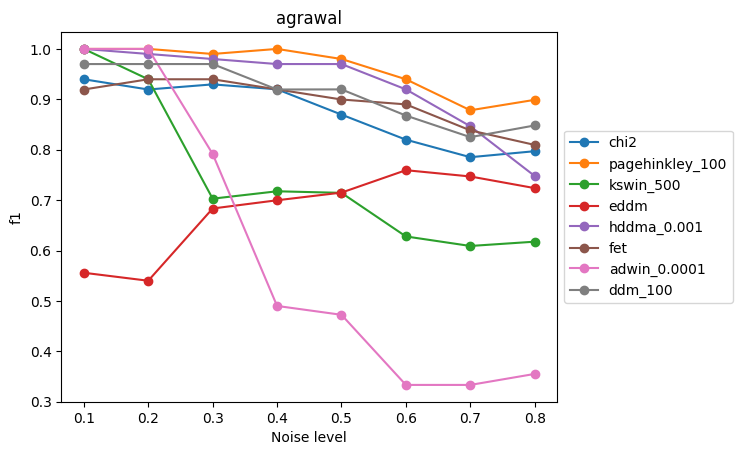

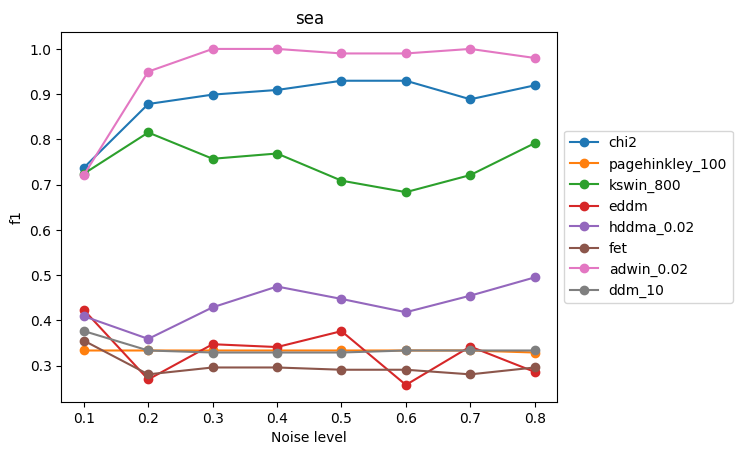

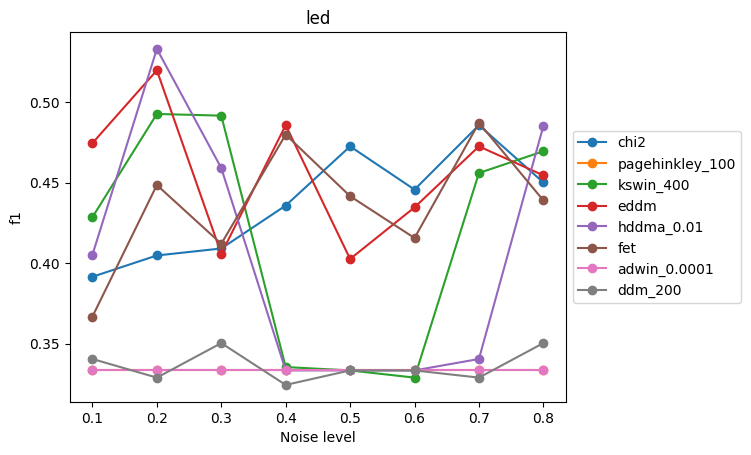

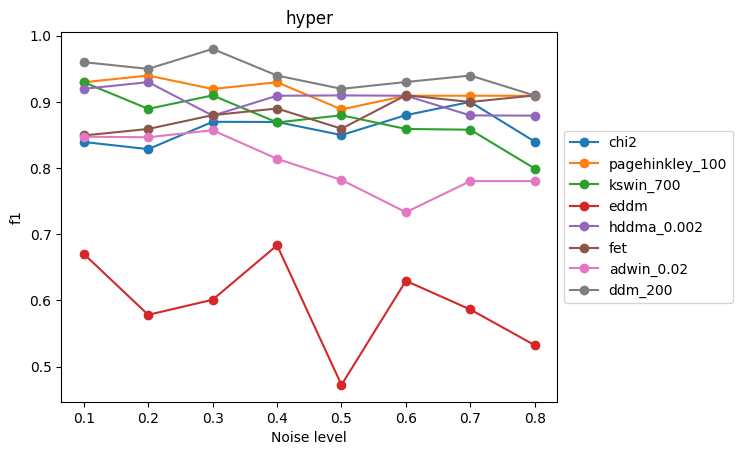

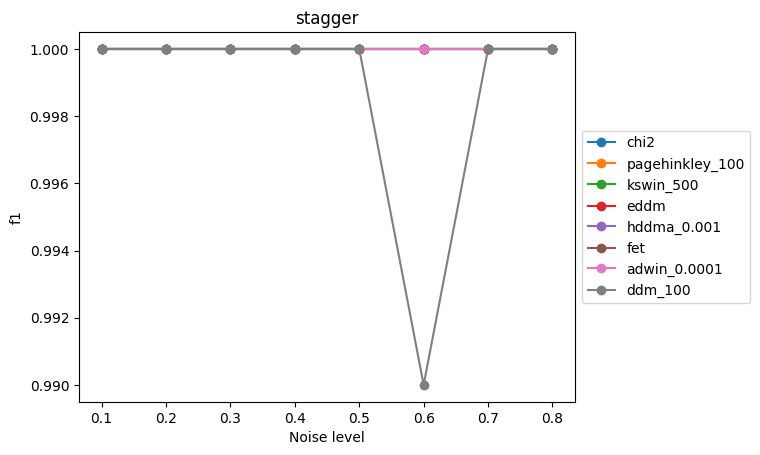

In [7]:
metric = 'f1'
for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:
    
    # Select the best method for each dataset
    noise = 0.1

    result_dataset_i = res_dataset_method_noise[exp_type]
    methods = set(result_dataset_i.keys())
    base_methods = set([method.split('_')[0] for method in result_dataset_i])

    # Take the configuration of the base method with the highest f1 score
    best_methods = []
    for base_method in base_methods:
        scores = {method: result_dataset_i[method][metric][noise] for method in methods if method.split('_')[0]==base_method}
        # get the method with the highest f1 score
        best_methods.append(max(scores, key=scores.get))


    for method in best_methods:
        best_method_values = res_dataset_method_noise[exp_type][method][metric]

        noise_levels = list(best_method_values.keys())
        vals = list(best_method_values.values())

        import matplotlib.pyplot as plt
        plt.plot(noise_levels, vals, label = method, marker='o')    
        plt.xlabel('Noise level')
        plt.ylabel(f'{metric}')
        plt.title(f'{exp_type}')
        # Show the legend outside the plot
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [17]:
metric = 'f1'
dataset_method_rankings = {}
for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:
    dataset_method_rankings[exp_type] = {}
    # Select the best method for each dataset
    noise = 0.1

    result_dataset_i = res_dataset_method_noise[exp_type]
    methods = set(result_dataset_i.keys())
    base_methods = set([method.split('_')[0] for method in result_dataset_i])

    # Take the configuration of the base method with the highest f1 score
    best_methods = []
    for base_method in base_methods:
        scores = {method: result_dataset_i[method][metric][noise] for method in methods if method.split('_')[0]==base_method}
        # get the method with the highest f1 score
        best_methods.append(max(scores, key=scores.get))
        # Sort the scores by value
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # Add a column with the rank
        rank = [i+1 for i in range(len(sorted_scores))]
        sorted_scores = [(method, score, rank) for (method, score), rank in zip(sorted_scores, rank)]
        sorted_scores
        dataset_method_rankings[exp_type][base_method] = sorted_scores

In [26]:

for base_method in base_methods:
    print(base_method)
    df_all = None
    for exp_type in dataset_method_rankings:
        vals = dataset_method_rankings[exp_type][base_method]
        df = pd.DataFrame(vals, columns=['method', f'{metric}_{exp_type}', exp_type])
        df.set_index('method', inplace=True)
        if df_all is None:
            df_all = df
        else:
            df_all = df_all.join(df)
    display(df_all)

chi2


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
chi2,0.939783,1,0.737374,1,0.391526,1,0.839422,1,1.0,1


pagehinkley


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
pagehinkley_100,1.0,1,0.333333,1,0.333333,1,0.929655,1,1.0,1
pagehinkley_200,1.0,2,0.333333,2,0.333333,2,0.929655,2,1.0,2
pagehinkley_30,1.0,3,0.333333,3,0.333333,3,0.929655,3,1.0,3
pagehinkley_50,1.0,4,0.333333,4,0.333333,4,0.929655,4,1.0,4
pagehinkley_10,1.0,5,0.333333,5,0.333333,5,0.929655,5,1.0,5
pagehinkley_5,1.0,6,0.333333,6,0.333333,6,0.929655,6,1.0,6


kswin


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
kswin_500,1.000000,1,0.539895,4,0.320058,9,0.837662,4,1.000000,1
kswin_800,1.000000,2,0.724109,1,0.338863,8,0.919711,2,1.000000,2
kswin_300,1.000000,3,0.416540,6,0.386946,5,0.794745,6,1.000000,3
kswin_400,1.000000,4,0.435737,5,0.428571,1,0.836801,5,1.000000,4
kswin_700,1.000000,5,0.690667,2,0.362904,7,0.929655,1,1.000000,5
kswin_600,1.000000,6,0.631076,3,0.368864,6,0.889458,3,1.000000,7
kswin_200,0.989999,7,0.368626,7,0.419280,2,0.719888,7,1.000000,6
kswin_100,0.949955,8,0.351339,8,0.419280,3,0.681664,8,0.989999,8
kswin_50,0.879227,9,0.304163,9,0.399498,4,0.604167,9,0.929655,9


eddm


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
eddm,0.555867,1,0.423019,1,0.474569,1,0.67033,1,1.0,1


hddma


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
hddma_0.001,1.000000,1,0.324324,5,0.350312,5,0.919485,2,1.0,1
hddma_0.0002,1.000000,2,0.333333,3,0.355178,4,0.909265,3,1.0,2
hddma_0.0001,1.000000,3,0.333333,4,0.333333,6,0.898990,4,1.0,5
hddma_0.002,0.989999,4,0.324324,6,0.371069,3,0.919711,1,1.0,6
hddma_0.01,0.949875,5,0.368626,2,0.405229,1,0.889901,5,1.0,4
hddma_0.02,0.929655,6,0.409107,1,0.395833,2,0.848775,6,1.0,3


fet


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
fet,0.919485,1,0.355159,1,0.366802,1,0.849261,1,1.0,1


adwin


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
adwin_0.0001,1.0,1,0.507152,6,0.333333,1,0.615559,6,1.0,1
adwin_0.002,1.0,2,0.601140,3,0.333333,2,0.733333,3,1.0,2
adwin_0.02,1.0,3,0.721150,1,0.328859,5,0.847421,1,1.0,3
adwin_0.01,1.0,4,0.708769,2,0.328859,6,0.846547,2,1.0,4
adwin_0.001,1.0,5,0.601140,4,0.333333,3,0.708769,4,1.0,5
adwin_0.0002,1.0,6,0.540040,5,0.333333,4,0.657042,5,1.0,6


ddm


,f1_agrawal,agrawal,f1_sea,sea,f1_led,led,f1_hyper,hyper,f1_stagger,stagger
method,,,,,,,,,,
ddm_100,0.969973,1,0.365804,5,0.319728,2,0.939904,3,1.0,1
ddm_10,0.969973,2,0.376299,1,0.319728,3,0.898990,6,1.0,2
ddm_30,0.969973,3,0.376299,2,0.319728,4,0.909265,5,1.0,3
ddm_200,0.969973,4,0.371069,4,0.340436,1,0.959984,1,1.0,5
ddm_5,0.959936,5,0.376299,3,0.319728,5,0.919485,4,1.0,4
ddm_50,0.959936,6,0.355178,6,0.319728,6,0.949875,2,1.0,6


In [29]:
overall_best_methods = ["chi2", "pagehinkley_100", "kswin_700", "eddm", "hddma_0.001", "fet", "adwin_0.01", "ddm_200"]

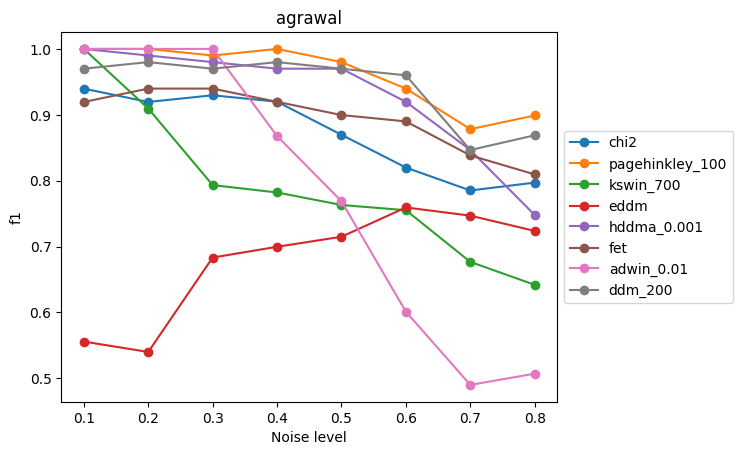

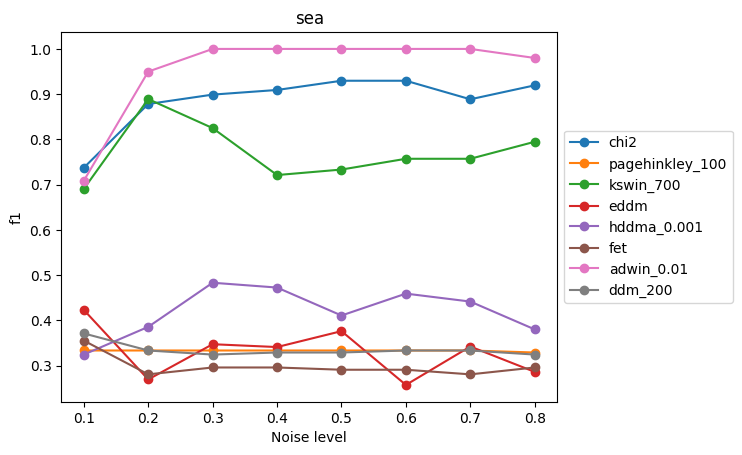

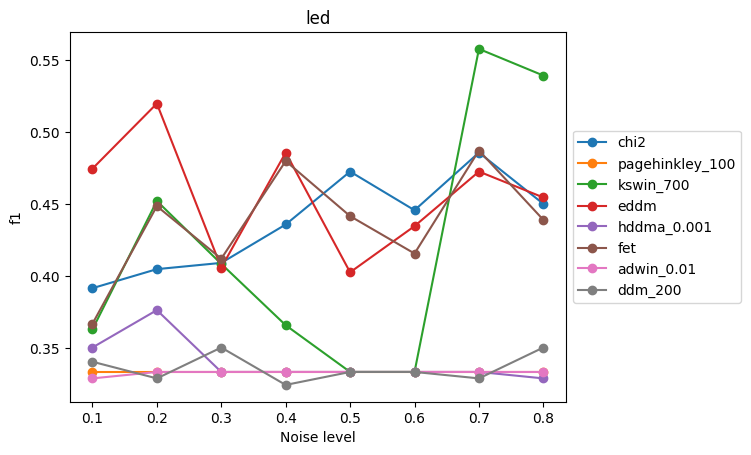

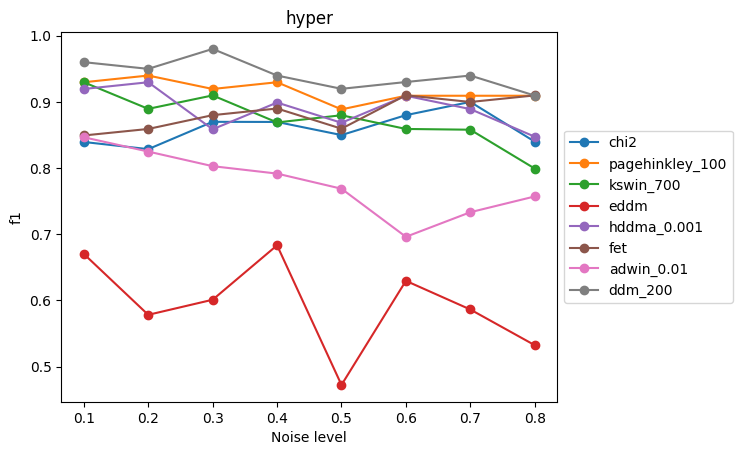

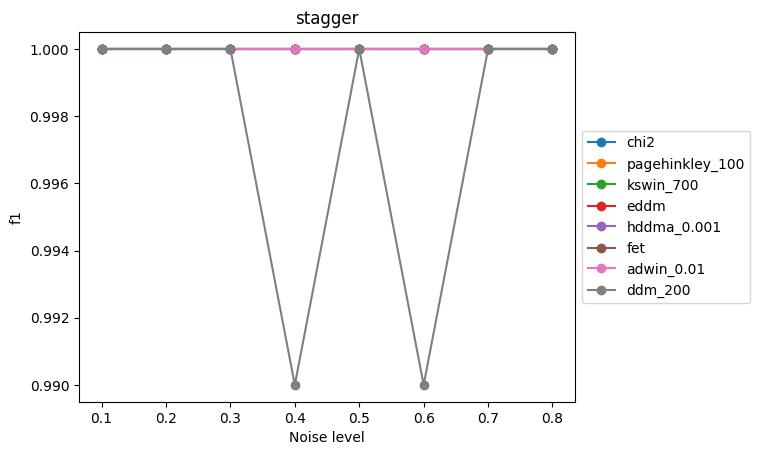

In [28]:
metric = 'f1'

for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:

    for method in overall_best_methods:
        best_method_values = res_dataset_method_noise[exp_type][method][metric]

        noise_levels = list(best_method_values.keys())
        vals = list(best_method_values.values())

        import matplotlib.pyplot as plt
        plt.plot(noise_levels, vals, label = method, marker='o')    
        plt.xlabel('Noise level')
        plt.ylabel(f'{metric}')
        plt.title(f'{exp_type}')
        # Show the legend outside the plot
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [39]:
metric = 'f1'

store_best_results = {}
for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:
    store_best_results[exp_type] = {}
    for method in overall_best_methods:
        best_method_values = res_dataset_method_noise[exp_type][method][metric]
        store_best_results[exp_type][method] = best_method_values
    display(pd.DataFrame(store_best_results[exp_type]))

# Store results
import pickle
# Create folder if it does not exist
pathlib.Path('summary_results').mkdir(parents=True, exist_ok=True)
with open(f'summary_results/results-overall-best-methods-{metric}-noise.pkl', 'wb') as f:
    pickle.dump(store_best_results, f)

,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.939783,1.000000,1.000000,0.555867,1.000000,0.919485,1.000000,0.969973
0.2,0.919485,1.000000,0.909557,0.540040,0.989999,0.939783,1.000000,0.979992
0.3,0.929655,0.989999,0.793303,0.683372,0.979992,0.939783,1.000000,0.969997
0.4,0.919872,1.000000,0.782135,0.699700,0.969997,0.919711,0.867765,0.979992
0.5,0.869674,0.979992,0.763155,0.714919,0.969997,0.899639,0.768810,0.969973
0.6,0.819928,0.939783,0.755202,0.759389,0.919711,0.889989,0.601140,0.959936
0.7,0.785166,0.878247,0.676768,0.746938,0.846547,0.838384,0.490044,0.846547
0.8,0.797078,0.898990,0.641944,0.723785,0.747793,0.809524,0.507152,0.868938


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.737374,0.333333,0.690667,0.423019,0.324324,0.355159,0.708769,0.371069
0.2,0.878247,0.333333,0.889102,0.269342,0.385580,0.280576,0.949875,0.333333
0.3,0.898990,0.333333,0.824941,0.347205,0.483111,0.295775,1.000000,0.324324
0.4,0.909265,0.333333,0.721150,0.340935,0.472457,0.295775,1.000000,0.328859
0.5,0.929655,0.333333,0.733333,0.376114,0.410658,0.290780,1.000000,0.328859
0.6,0.929655,0.333333,0.757153,0.257216,0.459070,0.290780,1.000000,0.333333
0.7,0.888653,0.333333,0.757153,0.342105,0.441476,0.280576,1.000000,0.333333
0.8,0.919485,0.328859,0.794745,0.286006,0.379960,0.295775,0.979992,0.324324


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.391526,0.333333,0.362904,0.474569,0.350312,0.366802,0.328859,0.340436
0.2,0.404762,0.333333,0.452110,0.519808,0.376299,0.448529,0.333333,0.328859
0.3,0.409107,0.333333,0.408405,0.405772,0.333333,0.412031,0.333333,0.350312
0.4,0.435778,0.333333,0.365804,0.485741,0.333333,0.479873,0.333333,0.324324
0.5,0.472562,0.333333,0.333333,0.402574,0.333333,0.441595,0.333333,0.333333
0.6,0.445689,0.333333,0.333333,0.434645,0.333333,0.415615,0.333333,0.333333
0.7,0.485741,0.333333,0.557761,0.472562,0.333333,0.487179,0.333333,0.328859
0.8,0.450118,0.333333,0.539263,0.454545,0.328859,0.438990,0.333333,0.350312


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.839422,0.929655,0.929655,0.670330,0.919485,0.849261,0.846547,0.959984
0.2,0.828612,0.939783,0.889458,0.578348,0.929655,0.859098,0.824941,0.949875
0.3,0.869883,0.919485,0.909774,0.601140,0.858586,0.879952,0.802884,0.979992
0.4,0.869674,0.929655,0.868938,0.683372,0.898990,0.889989,0.791667,0.939783
0.5,0.849865,0.888653,0.879808,0.472457,0.868408,0.859494,0.768810,0.919711
0.6,0.879952,0.909265,0.859098,0.629671,0.909265,0.909991,0.696181,0.929993
0.7,0.899960,0.909265,0.857955,0.586397,0.889102,0.899840,0.733333,0.939783
0.8,0.839936,0.909265,0.799277,0.532492,0.847421,0.909774,0.757153,0.909557


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989999
0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989999
0.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


# Show average

In [38]:
metric = 'f1'
avg_results = {}    
for exp_type in ["agrawal", "sea", "led", "hyper", "stagger"]:
    avg_results[exp_type] = {}
    for method in res_dataset_method_noise[exp_type]:
        import numpy as np
        avg_results[exp_type][method] = np.array(list(res_dataset_method_noise[exp_type][method][metric].values())).mean()

df_avg_results_all = pd.DataFrame(avg_results)

df_avg_results_all.sort_index()

,agrawal,sea,led,hyper,stagger
adwin_0.0001,0.597002,0.920803,0.333333,0.556913,1.000000
adwin_0.0002,0.625441,0.928704,0.333333,0.581192,1.000000
adwin_0.001,0.671473,0.938862,0.333333,0.665404,1.000000
adwin_0.002,0.695872,0.940123,0.333333,0.693238,1.000000
adwin_0.01,0.779364,0.954829,0.332774,0.777690,1.000000
adwin_0.02,0.822123,0.953877,0.331655,0.805154,1.000000
chi2,0.872580,0.886415,0.436910,0.859663,1.000000
ddm_10,0.819152,0.337026,0.328813,0.858779,0.998750
ddm_100,0.911254,0.335147,0.330376,0.915763,0.998750
ddm_200,0.943169,0.334679,0.336221,0.941085,0.997500


# Load summary results

In [2]:
import pandas as pd
import pickle

In [3]:
metric = 'f1'
with open(f'summary_results/results-overall-best-methods-{metric}-noise.pkl', 'rb') as f:
    store_best_results = pickle.load(f)

In [4]:
for dataset in store_best_results:
    print(dataset)
    display(pd.DataFrame(store_best_results[dataset]))

agrawal


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.939783,1.000000,1.000000,0.555867,1.000000,0.919485,1.000000,0.969973
0.2,0.919485,1.000000,0.909557,0.540040,0.989999,0.939783,1.000000,0.979992
0.3,0.929655,0.989999,0.793303,0.683372,0.979992,0.939783,1.000000,0.969997
0.4,0.919872,1.000000,0.782135,0.699700,0.969997,0.919711,0.867765,0.979992
0.5,0.869674,0.979992,0.763155,0.714919,0.969997,0.899639,0.768810,0.969973
0.6,0.819928,0.939783,0.755202,0.759389,0.919711,0.889989,0.601140,0.959936
0.7,0.785166,0.878247,0.676768,0.746938,0.846547,0.838384,0.490044,0.846547
0.8,0.797078,0.898990,0.641944,0.723785,0.747793,0.809524,0.507152,0.868938


sea


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.737374,0.333333,0.690667,0.423019,0.324324,0.355159,0.708769,0.371069
0.2,0.878247,0.333333,0.889102,0.269342,0.385580,0.280576,0.949875,0.333333
0.3,0.898990,0.333333,0.824941,0.347205,0.483111,0.295775,1.000000,0.324324
0.4,0.909265,0.333333,0.721150,0.340935,0.472457,0.295775,1.000000,0.328859
0.5,0.929655,0.333333,0.733333,0.376114,0.410658,0.290780,1.000000,0.328859
0.6,0.929655,0.333333,0.757153,0.257216,0.459070,0.290780,1.000000,0.333333
0.7,0.888653,0.333333,0.757153,0.342105,0.441476,0.280576,1.000000,0.333333
0.8,0.919485,0.328859,0.794745,0.286006,0.379960,0.295775,0.979992,0.324324


led


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.391526,0.333333,0.362904,0.474569,0.350312,0.366802,0.328859,0.340436
0.2,0.404762,0.333333,0.452110,0.519808,0.376299,0.448529,0.333333,0.328859
0.3,0.409107,0.333333,0.408405,0.405772,0.333333,0.412031,0.333333,0.350312
0.4,0.435778,0.333333,0.365804,0.485741,0.333333,0.479873,0.333333,0.324324
0.5,0.472562,0.333333,0.333333,0.402574,0.333333,0.441595,0.333333,0.333333
0.6,0.445689,0.333333,0.333333,0.434645,0.333333,0.415615,0.333333,0.333333
0.7,0.485741,0.333333,0.557761,0.472562,0.333333,0.487179,0.333333,0.328859
0.8,0.450118,0.333333,0.539263,0.454545,0.328859,0.438990,0.333333,0.350312


hyper


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.839422,0.929655,0.929655,0.670330,0.919485,0.849261,0.846547,0.959984
0.2,0.828612,0.939783,0.889458,0.578348,0.929655,0.859098,0.824941,0.949875
0.3,0.869883,0.919485,0.909774,0.601140,0.858586,0.879952,0.802884,0.979992
0.4,0.869674,0.929655,0.868938,0.683372,0.898990,0.889989,0.791667,0.939783
0.5,0.849865,0.888653,0.879808,0.472457,0.868408,0.859494,0.768810,0.919711
0.6,0.879952,0.909265,0.859098,0.629671,0.909265,0.909991,0.696181,0.929993
0.7,0.899960,0.909265,0.857955,0.586397,0.889102,0.899840,0.733333,0.939783
0.8,0.839936,0.909265,0.799277,0.532492,0.847421,0.909774,0.757153,0.909557


stagger


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989999
0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989999
0.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


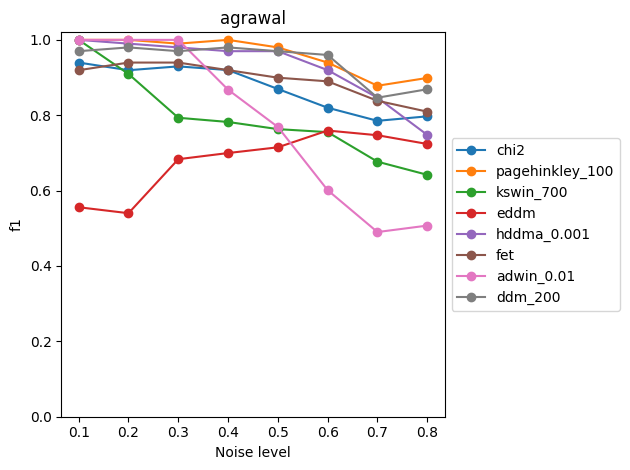

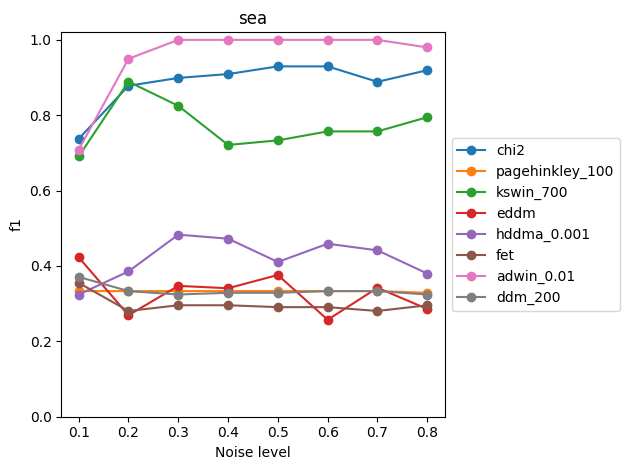

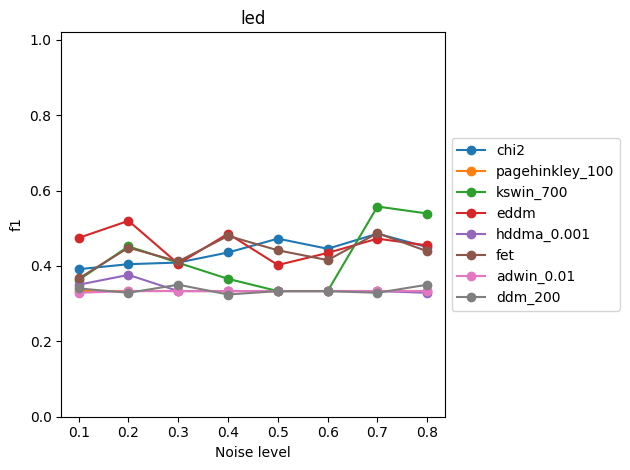

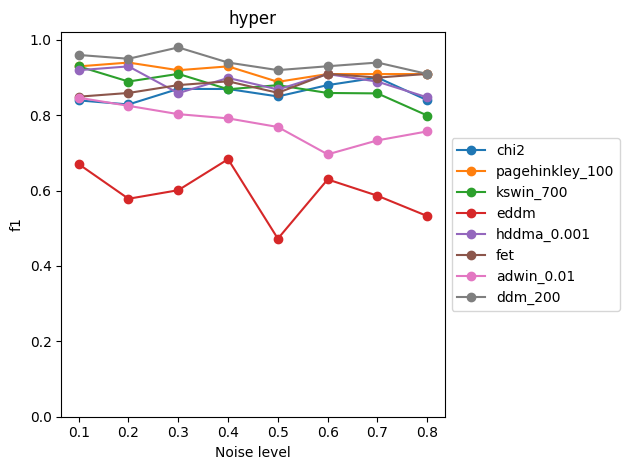

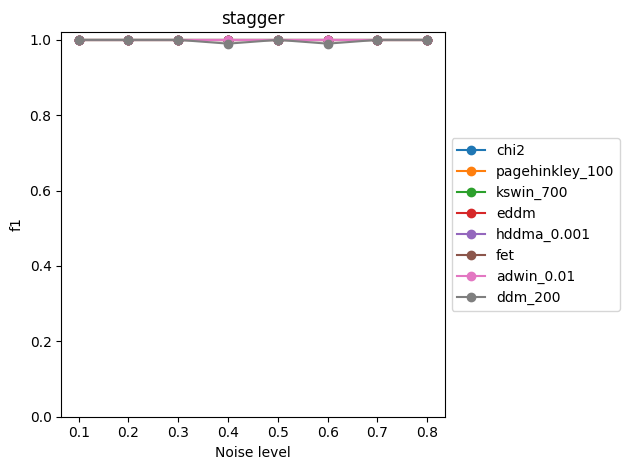

In [5]:
for dataset in store_best_results:
    for method in store_best_results[dataset]:
        noise_vs_values = store_best_results[dataset][method]

        noise_levels = list(noise_vs_values.keys())
        vals = list(noise_vs_values.values())

        import matplotlib.pyplot as plt
        plt.plot(noise_levels, vals, label = method, marker='o')    
        plt.xlabel('Noise level')
        plt.ylabel(f'{metric}')
        plt.title(f'{dataset}')
        plt.ylim(0, 1+0.02)
        # Show the legend outside the plot
        plt.tight_layout()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
for dataset in store_best_results:
    print(dataset)
    display(pd.DataFrame(store_best_results[dataset]))

agrawal


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.939783,1.000000,1.000000,0.555867,1.000000,0.919485,1.000000,0.969973
0.2,0.919485,1.000000,0.909557,0.540040,0.989999,0.939783,1.000000,0.979992
0.3,0.929655,0.989999,0.793303,0.683372,0.979992,0.939783,1.000000,0.969997
0.4,0.919872,1.000000,0.782135,0.699700,0.969997,0.919711,0.867765,0.979992
0.5,0.869674,0.979992,0.763155,0.714919,0.969997,0.899639,0.768810,0.969973
0.6,0.819928,0.939783,0.755202,0.759389,0.919711,0.889989,0.601140,0.959936
0.7,0.785166,0.878247,0.676768,0.746938,0.846547,0.838384,0.490044,0.846547
0.8,0.797078,0.898990,0.641944,0.723785,0.747793,0.809524,0.507152,0.868938


sea


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.737374,0.333333,0.690667,0.423019,0.324324,0.355159,0.708769,0.371069
0.2,0.878247,0.333333,0.889102,0.269342,0.385580,0.280576,0.949875,0.333333
0.3,0.898990,0.333333,0.824941,0.347205,0.483111,0.295775,1.000000,0.324324
0.4,0.909265,0.333333,0.721150,0.340935,0.472457,0.295775,1.000000,0.328859
0.5,0.929655,0.333333,0.733333,0.376114,0.410658,0.290780,1.000000,0.328859
0.6,0.929655,0.333333,0.757153,0.257216,0.459070,0.290780,1.000000,0.333333
0.7,0.888653,0.333333,0.757153,0.342105,0.441476,0.280576,1.000000,0.333333
0.8,0.919485,0.328859,0.794745,0.286006,0.379960,0.295775,0.979992,0.324324


led


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.391526,0.333333,0.362904,0.474569,0.350312,0.366802,0.328859,0.340436
0.2,0.404762,0.333333,0.452110,0.519808,0.376299,0.448529,0.333333,0.328859
0.3,0.409107,0.333333,0.408405,0.405772,0.333333,0.412031,0.333333,0.350312
0.4,0.435778,0.333333,0.365804,0.485741,0.333333,0.479873,0.333333,0.324324
0.5,0.472562,0.333333,0.333333,0.402574,0.333333,0.441595,0.333333,0.333333
0.6,0.445689,0.333333,0.333333,0.434645,0.333333,0.415615,0.333333,0.333333
0.7,0.485741,0.333333,0.557761,0.472562,0.333333,0.487179,0.333333,0.328859
0.8,0.450118,0.333333,0.539263,0.454545,0.328859,0.438990,0.333333,0.350312


hyper


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,0.839422,0.929655,0.929655,0.670330,0.919485,0.849261,0.846547,0.959984
0.2,0.828612,0.939783,0.889458,0.578348,0.929655,0.859098,0.824941,0.949875
0.3,0.869883,0.919485,0.909774,0.601140,0.858586,0.879952,0.802884,0.979992
0.4,0.869674,0.929655,0.868938,0.683372,0.898990,0.889989,0.791667,0.939783
0.5,0.849865,0.888653,0.879808,0.472457,0.868408,0.859494,0.768810,0.919711
0.6,0.879952,0.909265,0.859098,0.629671,0.909265,0.909991,0.696181,0.929993
0.7,0.899960,0.909265,0.857955,0.586397,0.889102,0.899840,0.733333,0.939783
0.8,0.839936,0.909265,0.799277,0.532492,0.847421,0.909774,0.757153,0.909557


stagger


,chi2,pagehinkley_100,kswin_700,eddm,hddma_0.001,fet,adwin_0.01,ddm_200
0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989999
0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.989999
0.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000


In [16]:
# Plot results with a specific nois
noise = 0.1

single_noise_results = {dataset: {method:store_best_results[dataset][method][noise] for method in store_best_results[dataset]} for dataset in store_best_results}

df_single = pd.DataFrame(single_noise_results)
df_single.sort_index()

,agrawal,sea,led,hyper,stagger
adwin_0.01,1.000000,0.708769,0.328859,0.846547,1.0
chi2,0.939783,0.737374,0.391526,0.839422,1.0
ddm_200,0.969973,0.371069,0.340436,0.959984,1.0
eddm,0.555867,0.423019,0.474569,0.670330,1.0
fet,0.919485,0.355159,0.366802,0.849261,1.0
hddma_0.001,1.000000,0.324324,0.350312,0.919485,1.0
kswin_700,1.000000,0.690667,0.362904,0.929655,1.0
pagehinkley_100,1.000000,0.333333,0.333333,0.929655,1.0


In [17]:
avg_noise_results = {}

for dataset in store_best_results:
    avg_noise_results[dataset] = dict(pd.DataFrame(store_best_results[dataset]).mean())

df_avg = pd.DataFrame(avg_noise_results)
df_avg.sort_index()

,agrawal,sea,led,hyper,stagger
adwin_0.01,0.779364,0.954829,0.332774,0.777690,1.0000
chi2,0.872580,0.886415,0.436910,0.859663,1.0000
ddm_200,0.943169,0.334679,0.336221,0.941085,0.9975
eddm,0.678001,0.330243,0.456277,0.594276,1.0000
fet,0.894537,0.298149,0.436327,0.882175,1.0000
hddma_0.001,0.928005,0.419580,0.340267,0.890114,1.0000
kswin_700,0.790258,0.771031,0.419114,0.874246,1.0000
pagehinkley_100,0.960876,0.332774,0.333333,0.916878,1.0000


In [18]:
df_avg.drop(['eddm'], axis=0).sort_index()

,agrawal,sea,led,hyper,stagger
adwin_0.01,0.779364,0.954829,0.332774,0.777690,1.0000
chi2,0.872580,0.886415,0.436910,0.859663,1.0000
ddm_200,0.943169,0.334679,0.336221,0.941085,0.9975
fet,0.894537,0.298149,0.436327,0.882175,1.0000
hddma_0.001,0.928005,0.419580,0.340267,0.890114,1.0000
kswin_700,0.790258,0.771031,0.419114,0.874246,1.0000
pagehinkley_100,0.960876,0.332774,0.333333,0.916878,1.0000


# This is just for test purposes

In [9]:

from skmultiflow.data import ConceptDriftStream


from sklearn.tree import DecisionTreeClassifier

def train_and_drift_overall(
    DataSource,
    drift=True,
    ds_kwargs={},
    train_size=5_000,
    n_batches=50,
    batch_size=200,
    ClfModel=DecisionTreeClassifier,
    clf_kwargs={},
    overall_detectors_args={},
):
    """Train a classifier on a stream and detect drift using multiple detectors
    args:
        DataSource: class that generates the data stream
        drift: whether to include drift in the data stream
        ds_kwargs: arguments to pass to the DataSource class
        train_size: number of samples to use for training
        n_batches: number of batches
        batch_size: size of each batch
        ClfModel: classifier model to use
        clf_kwargs: arguments to pass to the classifier
        overall_detectors_args: arguments to pass to the drift detectors
    returns:
        overall_drift_result: dictionary containing the results of the drift detection
    """

    # Import drift detectors
    from skmultiflow.drift_detection.hddm_a import HDDM_A
    from skmultiflow.drift_detection.eddm import EDDM
    from skmultiflow.drift_detection import DDM
    from skmultiflow.drift_detection.adwin import ADWIN
    from alibi_detect.cd import ChiSquareDrift, FETDrift



    if overall_detectors_args == {}:
        # Set default values for the drift detectors
        overall_detectors_args = {
            "hddma_drift_confidence": [0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02],
            "ddm_min_num_instances": [5, 10, 30, 50, 100, batch_size],
            "adwin_delta": [0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02],
            "eddm": None,
            "chi2": 0.05,  # pvalue
            "fet" : 0.05 # pvalue
        }

    tot_samples = n_batches * batch_size  # total number of samples
    position = (n_batches // 2) * batch_size  # "center" of the drift
    width = (n_batches // 4) * batch_size  # size of the transitory

    data_source = DataSource(**ds_kwargs)
    stream = data_source.stream
    drift_stream = data_source.drift_stream

    if drift:
        # If drift is True, we use a different stream for the drift, i.e., the drift_stream
        cds = ConceptDriftStream(
            stream=stream, drift_stream=drift_stream, position=position, width=width
        )
    else:
        # If drift is False, we use the same stream for both
        cds = ConceptDriftStream(
            stream=stream, drift_stream=stream, position=position, width=width
        )  # no drift!

    X_train, y_train = stream.next_sample(train_size)

    clf = ClfModel(**clf_kwargs)
    clf.fit(X_train, y_train)

    detectors_dict = {}

    # Initialize drift detectors
    if "hddma_drift_confidence" in overall_detectors_args:
        for hddma_params in overall_detectors_args["hddma_drift_confidence"]:
            hddma_i = HDDM_A(drift_confidence=hddma_params)
            detectors_dict[f"hddma_{hddma_params}"] = hddma_i

    if "ddm_min_num_instances" in overall_detectors_args:
        for ddm_params in overall_detectors_args["ddm_min_num_instances"]:
            ddm_i = DDM(min_num_instances=ddm_params)
            detectors_dict[f"ddm_{ddm_params}"] = ddm_i

    if "adwin_delta" in overall_detectors_args:
        for adwin_params in overall_detectors_args["adwin_delta"]:
            adwin_i = ADWIN(adwin_params)
            detectors_dict[f"adwin_{adwin_params}"] = adwin_i

    if "eddm" in overall_detectors_args:
        eddm = EDDM()
        detectors_dict["eddm"] = eddm

    if "chi2" in overall_detectors_args:
        detectors_dict["chi2"] = overall_detectors_args["chi2"]

    if "fet" in overall_detectors_args:
        # Fisher Exact Test
        detectors_dict["fet"] = overall_detectors_args["fet"]

    # y_pred_train = clf.predict(X_train).astype(int)

    # hddm_a, eddm: Whether the last sample analyzed was correctly classified or not. 1 indicates an error (miss-classification).
    # errors_train = (y_train.astype(int) != y_pred_train).astype(int)

    # ADWIN: 0: Means the learners prediction was wrong, 1: Means the learners prediction was correct
    # corrects_train = (y_train.astype(int) == y_pred_train).astype(int)

    """
    # Add the training data to the drift detector
    # We initialize the detectors with the training data
    for i in range(len(errors_train)):
        for detector_name, detector in zip(detector_names, detectors):
            if detector_name[0:5] == "adwin":
                # ADWIN use 1 for correct predictions, 0 for wrong predictions
                detector.add_element(corrects_train[i])
            else:
                # The others (hddm_a and eddm) use 1 for a wrong predictions, 0 for correct
                detector.add_element(errors_train[i])

    """

    # Initialize dictionaries to store the results
    detector_warnings = {detector_name: {} for detector_name in detectors_dict}
    detector_detected = {detector_name: {} for detector_name in detectors_dict}
    overall_drift_result = {detector_name: {} for detector_name in detectors_dict}

    for batch_idx in range(0, tot_samples, batch_size):
        X_batch, y_batch = cds.next_sample(batch_size)

        y_pred = clf.predict(X_batch)

        # hddm_a, eddm: Whether the last sample analyzed was correctly classified or not. 1 indicates an error (miss-classification).
        errors_b = (y_batch.astype(int) != y_pred).astype(int)

        # ADWIN: 0: Means the learners prediction was wrong, 1: Means the learners prediction was correct
        corrects_b = (y_batch.astype(int) == y_pred).astype(int)

        # We dot this oly for  "chi2" or "fet"  detectors:
        if batch_idx == 0:
            # We initialize chi and fet for the entire batch
            # overall_detectors_args['chi2'] and overall_detectors_args['fet']  is the p-value threshold for the chi-square test
            if "chi2" in detectors_dict:
                chi = ChiSquareDrift(errors_b, overall_detectors_args["chi2"])
                detectors_dict["chi2"] = chi
            if "fet" in detectors_dict:
                fet = FETDrift(errors_b, overall_detectors_args["fet"])
                detectors_dict["fet"] = fet
        else:
            for detector_name, detector in detectors_dict.items():
                if detector_name == "chi2" or detector_name == "fet":
                    # We evaluate chi or fet for the entire batch
                    preds = detectors_dict[detector_name].predict(errors_b)
                    is_drift = preds["data"]["is_drift"]
                    if is_drift:
                        # Add detected change to the dictionary
                        # We say that it detect a drift for all samples in the batch
                        detector_detected[detector_name][batch_idx] = [
                            1 for i in range(len(errors_b))
                        ]

        # For the other approaches, we iterate one sample at the time
        for i in range(len(errors_b)):
            for detector_name, detector in detectors_dict.items():
                if detector_name == "chi2" or detector_name == "fet":
                    # We skip chi2 and fet has we do the evaluation for the entire batch
                    continue
                elif detector_name[0:5] == "adwin":
                    detector.add_element(corrects_b[i])
                else:
                    detector.add_element(errors_b[i])

                # Start detecting change after the first batch
                if batch_idx >= 1:

                    if detector.detected_warning_zone():
                        # Add warning zone to the dictionary

                        if batch_idx not in detector_warnings[detector_name]:
                            detector_warnings[detector_name][batch_idx] = []
                        detector_warnings[detector_name][batch_idx].append(i)
                        # print('Warning zone has been detected in data: ' + str(errors_b[i]) + ' - of index: ' + str(i))
                    if detector.detected_change():
                        # Add detected change to the dictionary
                        # print(f"{detector_name} - Change has been detected in batch_idx: {batch_idx} - of index: {i}")
                        if batch_idx not in detector_detected[detector_name]:
                            detector_detected[detector_name][batch_idx] = []
                        detector_detected[detector_name][batch_idx].append(i)

    # Store subgroup results
    for detector_name in detector_detected:
        overall_drift_result[detector_name] = {
            # "warnings": detector_warnings[detector_name],
            "detected_batch": detector_detected[detector_name],
            "num_pts_detected": sum(
                [len(v) for v in detector_detected[detector_name].values()]
            ),
        }

    return overall_drift_result



In [10]:
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

from wrappers import (
    AgrawalWrapper,
    SEAWrapper,
    LEDWrapper,
    HyperplaneWrapper,
    STAGGERWrapper,
)

exp_type = 'agrawal'
n_exp = 5
train_size = 5000
n_batches = 50
batch_size = 200

print("Experiment type: ", exp_type)

overall_drift_results = {}
gt = []

if exp_type == "agrawal":
    DataClass = AgrawalWrapper
    data_kwargs = {"perturbation": 0.1}
if exp_type == "sea":
    DataClass = SEAWrapper
    data_kwargs = {"noise_percentage": 0.4}
elif exp_type == "led":
    DataClass = LEDWrapper
    data_kwargs = {"bounded_drift": 0.25, "noise_percentage": 0.1}
elif exp_type == "hyper":
    DataClass = HyperplaneWrapper
    data_kwargs = {}
elif exp_type == "stagger":
    DataClass = STAGGERWrapper
    data_kwargs = {}

i = 0
for drift in [False, True]:
    print(f"Drift: {drift}")
    for exp in tqdm(range(n_exp // 2)):  # positive samples

        overall_drift_result = train_and_drift_overall(
            DataClass,
            ds_kwargs={"random_state": i, **data_kwargs},
            drift=drift,
            train_size=train_size,
            n_batches=n_batches,
            batch_size=batch_size,
            ClfModel=DecisionTreeClassifier,
            clf_kwargs={},
            #overall_detectors_args={'chi2': 0.05}
        )

        for method in overall_drift_result:
            if method not in overall_drift_results:
                overall_drift_results[method] = []

            # Set to 1 if the experiment has drift, 0 otherwise
            overall_drift_result[method]["drift"] = int(drift)
            overall_drift_results[method].append(overall_drift_result[method])

            # print(exp, method, overall_drift_result[method])

        # gt[i] = drift
        gt.append(drift)

        i += 1


Experiment type:  agrawal
Drift: False


100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Drift: True


100%|██████████| 2/2 [00:06<00:00,  3.16s/it]


In [11]:
threshold = 1

for method in overall_drift_results:
        print(f"Method: {method}")
        overall_drift_result = overall_drift_results[method]
        # overall_drift_result[i]['drift'] is 1 if the experiment i has drift, 0 otherwise. We use this as the ground truth
        # Half of the experiments have drift, half do not
        gt = [overall_drift_result[i]['drift'] for i in range(len(overall_drift_result))]
        
        # Predictions are the number of drift points detected by the method
        predictions = [overall_drift_result[i]['num_pts_detected'] for i in range(len(overall_drift_result))]
        
        print(gt)
        print(predictions)
        
        # We say that drift is detected if the number of drift points detected is greater than a threshold
        predictions = list([pred > threshold for pred in predictions])
        #Convert to int predictions
        predictions=list(map(int, predictions))

Method: hddma_0.0001
[0, 0, 1, 1]
[0, 0, 2, 3]
Method: hddma_0.0002
[0, 0, 1, 1]
[0, 0, 2, 3]
Method: hddma_0.001
[0, 0, 1, 1]
[0, 0, 2, 3]
Method: hddma_0.002
[0, 0, 1, 1]
[1, 1, 3, 3]
Method: hddma_0.01
[0, 0, 1, 1]
[1, 0, 4, 6]
Method: hddma_0.02
[0, 0, 1, 1]
[2, 0, 4, 5]
Method: ddm_5
[0, 0, 1, 1]
[0, 0, 7, 6]
Method: ddm_10
[0, 0, 1, 1]
[0, 0, 8, 6]
Method: ddm_30
[0, 0, 1, 1]
[0, 0, 4, 4]
Method: ddm_50
[0, 0, 1, 1]
[0, 0, 4, 3]
Method: ddm_100
[0, 0, 1, 1]
[0, 0, 4, 4]
Method: ddm_200
[0, 0, 1, 1]
[0, 0, 4, 4]
Method: adwin_0.0001
[0, 0, 1, 1]
[0, 0, 12, 8]
Method: adwin_0.0002
[0, 0, 1, 1]
[0, 0, 12, 8]
Method: adwin_0.001
[0, 0, 1, 1]
[0, 0, 12, 9]
Method: adwin_0.002
[0, 0, 1, 1]
[0, 0, 12, 9]
Method: adwin_0.01
[0, 0, 1, 1]
[0, 0, 13, 11]
Method: adwin_0.02
[0, 0, 1, 1]
[0, 0, 14, 12]
Method: eddm
[0, 0, 1, 1]
[2, 1, 43, 26]
Method: chi2
[0, 0, 1, 1]
[200, 0, 5800, 5800]
Method: fet
[0, 0, 1, 1]
[0, 200, 5800, 6200]


In [12]:
overall_drift_results.keys()

dict_keys(['hddma_0.0001', 'hddma_0.0002', 'hddma_0.001', 'hddma_0.002', 'hddma_0.01', 'hddma_0.02', 'ddm_5', 'ddm_10', 'ddm_30', 'ddm_50', 'ddm_100', 'ddm_200', 'adwin_0.0001', 'adwin_0.0002', 'adwin_0.001', 'adwin_0.002', 'adwin_0.01', 'adwin_0.02', 'eddm', 'chi2', 'fet'])

In [13]:
import pandas as pd 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

threshold = 1

res = []

for method in overall_drift_results:

    overall_drift_result = overall_drift_results[method]
    # overall_drift_result[i]['drift'] is 1 if the experiment i has drift, 0 otherwise. We use this as the ground truth
    # Half of the experiments have drift, half do not
    gt = [overall_drift_result[i]['drift'] for i in range(len(overall_drift_result))]
    
    # Predictions are the number of drift points detected by the method
    predictions = [overall_drift_result[i]['num_pts_detected'] for i in range(len(overall_drift_result))]
    
    
    # We say that drift is detected if the number of drift points detected is greater than a threshold
    predictions = list([pred > threshold for pred in predictions])
    #Convert to int predictions
    predictions=list(map(int, predictions))


    acc = accuracy_score(gt, predictions)

    f1 = f1_score(gt, predictions)

    tn, fp, fn, tp = confusion_matrix(gt, predictions).ravel()

    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    res.append([method, acc, f1, fpr, fnr])

res = pd.DataFrame(res, columns=["method", "accuracy", "f1", "fpr", "fnr"])
print(exp_type)
display(res)

agrawal


,method,accuracy,f1,fpr,fnr
0,hddma_0.0001,1.00,1.0,0.0,0.0
1,hddma_0.0002,1.00,1.0,0.0,0.0
2,hddma_0.001,1.00,1.0,0.0,0.0
3,hddma_0.002,1.00,1.0,0.0,0.0
4,hddma_0.01,1.00,1.0,0.0,0.0
5,hddma_0.02,0.75,0.8,0.5,0.0
6,ddm_5,1.00,1.0,0.0,0.0
7,ddm_10,1.00,1.0,0.0,0.0
8,ddm_30,1.00,1.0,0.0,0.0
9,ddm_50,1.00,1.0,0.0,0.0
